In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

# TEST QSH


In [3]:
qsh = Dataset_QSH.Dataset_QSH()
import os
#file = ipysh.abs_builddir+'/te_db_r15_clean_shuffle.npy'
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
try: qsh.load(file)
except: raise FileNotFoundError

# qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm','absBt_rm','argBt_rm']) 
print("QSH rebalanced 15 points size: ", len(qsh))


QSH rebalanced 15 points size:  47567


In [4]:
def _map(xy,p,Br):
    pBr = tf.concat([p,Br], axis=0)
    return pBr,xy

ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm~absBt_rm~argBt_rm']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

W1004 06:47:00.289445 140678268921664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(<tf.Tensor: id=56, shape=(1, 44), dtype=float32, numpy=
 array([[0.38241032, 0.591622  , 0.7200023 , 0.52214116, 0.3112875 ,
         0.02783705, 0.02476765, 0.01490809, 0.01159484, 0.00981522,
         0.00481668, 0.00358146, 0.03149473, 0.01259113, 0.09446421,
         0.00517318, 0.6994813 , 0.52681905, 0.14240365, 0.17334197,
         0.23059171, 0.22648595, 0.8581499 , 0.99188983, 0.5722232 ,
         0.00430231, 0.02656434, 0.0374853 , 0.0261325 , 0.02346476,
         0.02050915, 0.01778544, 0.01607633, 0.01455928, 0.31291315,
         0.96958816, 0.03342261, 0.9135509 , 0.6404492 , 0.6341538 ,
         0.45444632, 0.2427145 , 0.26351297, 0.04488605]], dtype=float32)>,
 <tf.Tensor: id=57, shape=(1, 30), dtype=float32, numpy=
 array([[       nan,        nan,        nan, 0.20828514, 0.27427357,
         0.3485927 , 0.42948723, 0.51404023, 0.59859335, 0.6794879 ,
         0.75380695, 0.8197954 , 0.8768625 , 0.9253027 , 0.96593666,
                nan,        nan,        nan, 0.4904

In [7]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.compile( vae.optimizer, tf.losses.mse )
vae.load('step12_vae_ls_tesi')

AEFIT5 a ready:


In [8]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=44, dprate=0.1, scale=2, geometry=[20,20,10,10])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 a ready:


In [9]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=1955, shape=(1, 44), dtype=float32, numpy=
 array([[0.25542352, 0.89690715, 0.5000725 , 0.72894037, 0.6297897 ,
         0.01312985, 0.0324371 , 0.05359358, 0.01716399, 0.00990941,
         0.0400793 , 0.0399195 , 0.06290268, 0.04126021, 0.6044492 ,
         0.1787289 , 0.688863  , 0.4169602 , 0.569177  , 0.55776334,
         0.51906776, 0.51577735, 0.5848686 , 0.5530569 , 0.35387266,
         0.07624952, 0.0583109 , 0.07664161, 0.06004565, 0.05006363,
         0.03981413, 0.04301573, 0.0187492 , 0.02158177, 0.78949267,
         0.4092855 , 0.7506054 , 0.7082309 , 0.8146324 , 0.8425355 ,
         0.873515  , 0.9027877 , 0.92006683, 0.9131522 ]], dtype=float32)>,
 <tf.Tensor: id=1956, shape=(1, 6), dtype=float32, numpy=
 array([[-1.7226157 ,  0.08701155, -0.5887357 ,  0.67033434,  0.40336818,
         -0.20947173]], dtype=float32)>)

In [10]:
# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.
gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )

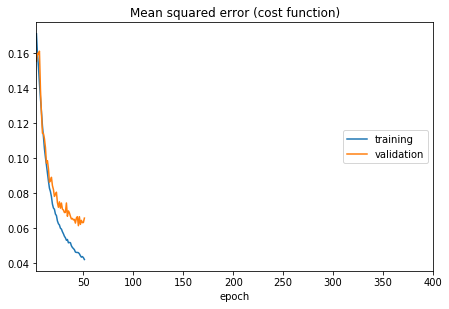

Mean squared error (cost function):
training   (min:    0.042, max:    0.212, cur:    0.042)
validation (min:    0.061, max:    0.193, cur:    0.066)
446/446 [==============================] - 102s 228ms/step - loss: 0.0420 - val_loss: 0.0657
Epoch 52/400
226/446 [==============>...............] - ETA: 52s - loss: 0.0424

In [221]:
fit = lambda: gen.fit( Dds.skip(3000).batch(100), validation_data=Dds.take(3000).batch(100), epochs=400,
                      callbacks=[PlotLossesCallback()], shuffle=False )
models.base.fn_thread(gen, fit).control_panel()

In [11]:
vae1.load('step12_7_thesis_BrBt')

In [12]:
pos = 0

0


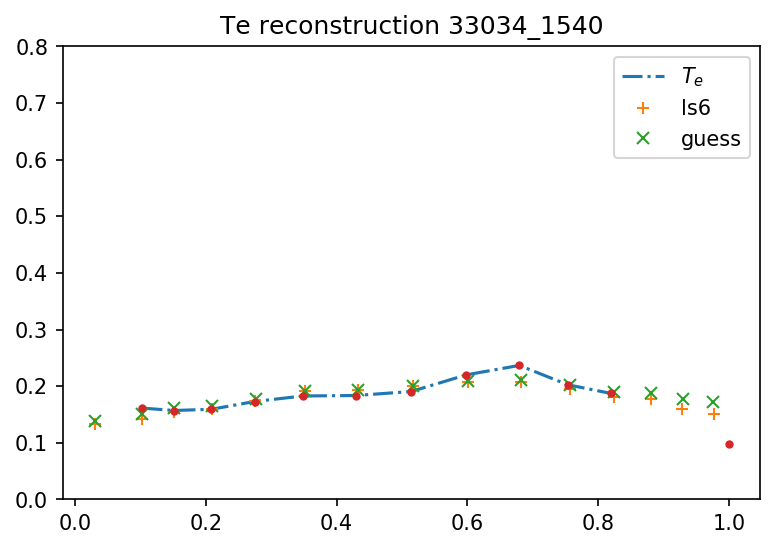

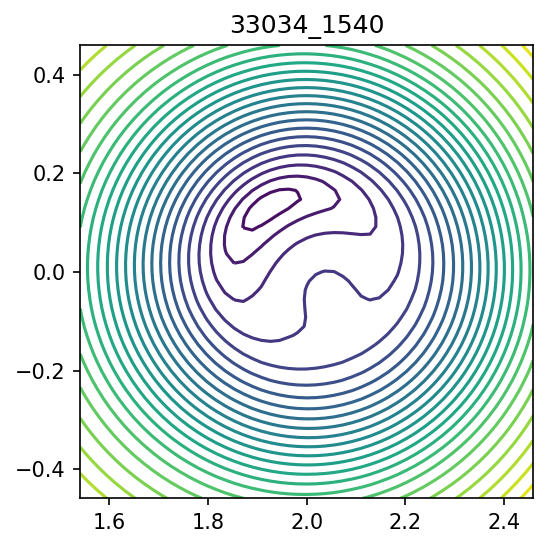

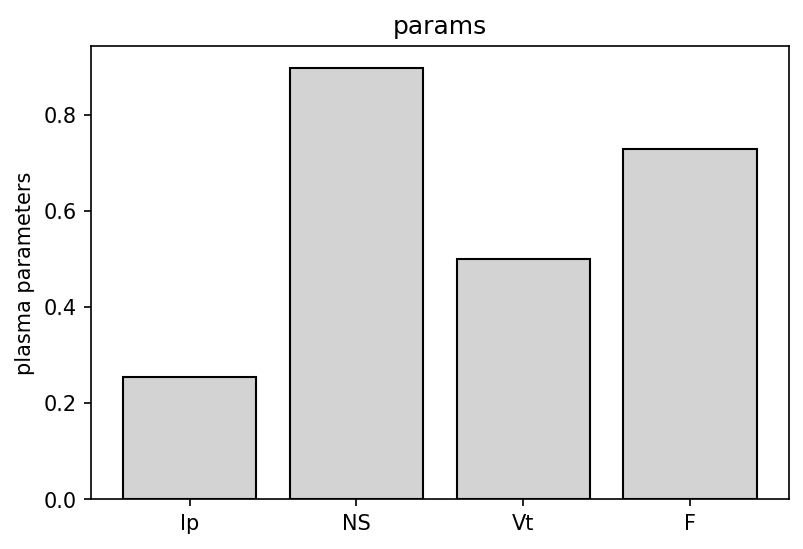

In [13]:
print(pos)

d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
path = '/home/andrea/Documents/phd/Thesis/img/STEP12/STEP12_7'


def plot_tf(xy, name=None, h='.'):
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,h, label=name)
    ax.legend()

def plot(x,y, name=None, h='.'):  
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,0.8)
    plt.plot(x,y, h, label=name)
    #ax.legend()
    
def plot_bar_x(index, w, title, w2=None):
    # this is for plotting purpose
    fig = plt.figure(title)
    fig.set_dpi(150)
    plt.bar(index, w, color='lightgrey', edgecolor='black')    
    plt.ylabel('plasma parameters', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    return fig
    

p  = d_pos[0]
xy = d_pos[1]

fig = plt.figure('plot')
# plt.text(0.05,0.7, '$I_p = %.2f$'%qsh[pos]['Ip'] )
ax = plt.gca()
ax.set_title( 'Te reconstruction '+qsh[pos].label.decode("utf-8") )

XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot_tf(xy, '$T_e$','-.')
plot_tf(XY_vae, 'ls6','+')
plot_tf(XY, 'guess','x')
plot(qsh[pos]['prel'],qsh[pos]['te'], '$T_c$')

fig2 = plt.figure('contour')
ax2  = plt.gca()
fig2.set_dpi(150)
qsh[pos].plot_countour(ax=ax2)
#fig2.savefig( path+'/Contour_'+str(pos)+'.png')

fig3 = plot_bar_x(['Ip','NS','Vt','F'], qsh[pos]['Ip~NS~VT~F'], 'params')
#fig3.savefig( path+'/Params_'+str(pos)+'.png')

fig = plt.figure('plot')
#fig.savefig( path+'/Te_rec_'+str(pos)+'.png')

# fig = plt.figure('Flux')
# fig.savefig(path+'/Te_Flux_'+str(pos)+'.png')



pos += 1

In [382]:
loss = {
    'mse' : [],
    'Ip' : [],
    'NS' : [],
    'Vt' : [],
    'F'  : [],
}
fig = plt.figure()
for pos in range(100):
    d_pos = [x for x in ds.skip(pos).batch(400).take(1)][0]
    p  = d_pos[0]
    xy = d_pos[1]
    XY_vae = vae(xy, training=False)
    ls = gen(d_pos[0], training=False)
    XY = vae.decode(ls, training=False)
    
    mse = tf.losses.mse(XY_vae,XY)
    # plot_tf(XY_vae, 'ls6','+')
    # plot_tf(XY, 'guess','x')
    for i in range(100):
        loss['mse'].append(mse[i].numpy())
        loss['Ip'].append(p[i][0].numpy())
        loss['NS'].append(p[i][1].numpy())
        loss['Vt'].append(p[i][2].numpy())
        loss['F'].append(p[i][3].numpy())
    

<Figure size 432x288 with 0 Axes>

10000


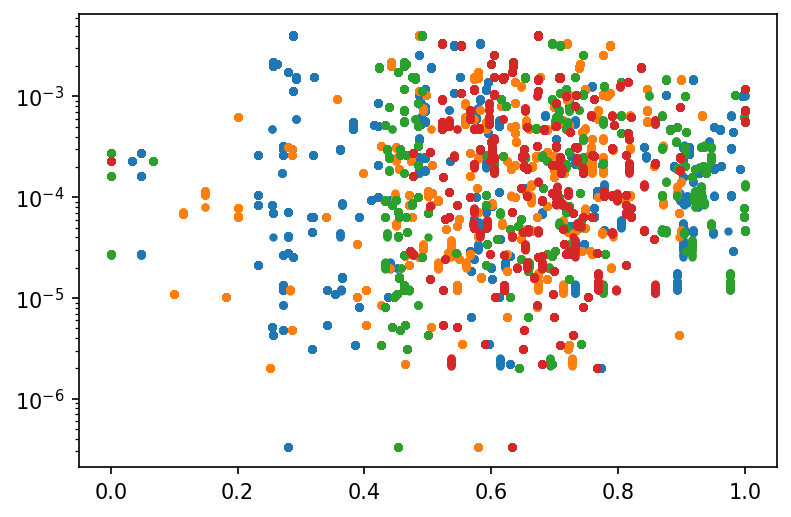

In [383]:
print(len(loss['mse']))
fig = plt.figure('params vs mse')
fig.set_dpi(150)
plt.yscale('log')
plt.plot(loss['Ip'],loss['mse'],'.')
plt.plot(loss['NS'],loss['mse'],'.')
plt.plot(loss['Vt'],loss['mse'],'.')
plt.plot(loss['F'],loss['mse'],'.')

<module 'tensorflow._api.v2.saved_model' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/saved_model/__init__.py'>